##### Hi Team
##### Thanks for the assignment and here is the general overview
 - Data and importing
 - EDA and pre-processing
 - Feature engineering and analysis ( location based features, distance(##decided not to use),time based features, direction of the ride, delta latt and delta long, and others)
 - For the model selection XGBoost and RandomForest are selected
 - for the Random forest hyperparameter tuning is also performed and feature importances are checked
 - For the XGboost decision tree base and linear base learners are checked
 
###### For the deployment i will use the AWS sagemager and other means of deployments are also possible. Here are the deployment steps:
 - Create a SageMaker notebook instance
 - Prepare the data
 - Train the model to learn from the data
 - Deploy the model
 - Evaluate your ML model's performance
  

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

#  Data

In [2]:
df = pd.read_csv(r'C:\Users\suhro\Downloads\robotex5.csv', parse_dates=["start_time"])
df.head(5)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


# Exploratory Data Analysis and Data Pre-Processing


In [3]:
df.shape

(627210, 6)

In [4]:
df.dtypes

start_time    datetime64[ns]
start_lat            float64
start_lng            float64
end_lat              float64
end_lng              float64
ride_value           float64
dtype: object

In [5]:
df = df[df["ride_value"] >= 0]
df.shape

(627210, 6)

In [6]:
df['year'] = df["start_time"].apply(lambda t: t.year)
df['weekday'] = df["start_time"].apply(lambda t: t.weekday())
df['hour'] = df["start_time"].apply(lambda t: t.hour)

In [7]:
print(df.isnull().sum())

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
year          0
weekday       0
hour          0
dtype: int64


In [8]:
df.head(5)

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,year,weekday,hour
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,2022,6,15
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,2022,3,11
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,2022,6,14
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,2022,3,9
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,2022,6,0


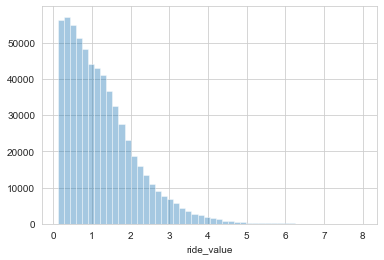

In [9]:
sns.distplot(df[df["ride_value"] < 8]["ride_value"], kde=False);

##### Tallin City coordinates are https://www.travelmath.com/cities/Tallinn,+Estonia

### Checking for outliers in Latitude and Longtitude

In [10]:
#for Tallin city 
latitude =  59
longitude =  24

In [11]:
print(min(df["start_lat"].min(), df["end_lat"].min()))

-37.81997867129488


In [12]:
print(max(df["start_lat"].max(), df["end_lat"].max()))

61.552743529950135


In [13]:
print(min(df["start_lng"].min(), df["end_lng"].min()))

-122.45396231296128


In [14]:
print(max(df["start_lng"].max(), df["end_lng"].max())) 

144.96610981279923


In [15]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value,year,weekday,hour
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000,627210.0,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384,2022.0,3.111086,12.845851
std,0.021764,0.056872,1.392755,1.650709,44.889892,0.0,1.940372,6.448740
min,59.321557,24.505199,-37.819979,-122.453962,0.107628,2022.0,0.000000,0.000000
25%,59.418803,24.713140,59.415215,24.707919,0.545250,2022.0,1.000000,8.000000
50%,59.432069,24.744674,59.430697,24.744335,1.059000,2022.0,3.000000,14.000000
75%,59.439024,24.768115,59.439262,24.773924,1.712000,2022.0,5.000000,18.000000
max,59.566998,24.973743,61.552744,144.966110,3172.701000,2022.0,6.000000,23.000000


In [16]:
BB = (24.5, 24.97, 59, 59.6)

In [17]:
## We will focus to boundaries of Tallinn city
def select_within_boundingbox(df, BB):
    return ((df["start_lng"] >= BB[0]) & (df["start_lng"] <= BB[1]) & 
            (df["end_lng"] >= BB[0]) & (df["end_lng"] <= BB[1]) & 
            (df["start_lat"] >= BB[2]) & (df["start_lat"] <= BB[3]) &
             (df["end_lat"] >= BB[2]) & (df["end_lat"] <= BB[3]))

In [18]:
df = df[select_within_boundingbox(df, BB)]
print("New size {}".format(len(df)))

New size 622924


### creating a distance between two points

In [19]:
## calculation of distance is based on Haversine formula
def distance(lat1, lon1, lat2, lon2):
  p = 0.017453292519943295 # Pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p))/2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))


In [20]:
df["distance_in_kilometers"] = distance(df["start_lat"], df["start_lng"], 
                                      df["end_lat"], df["end_lng"])

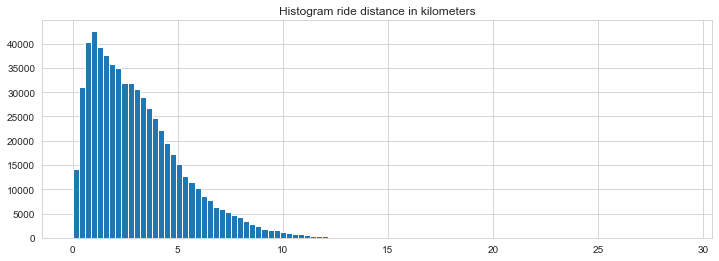

In [21]:
df["distance_in_kilometers"].hist(bins=100, figsize=(12,4))
plt.title("Histogram ride distance in kilometers");

In [22]:
df["distance_in_kilometers"].describe()

count    622924.000000
mean          3.089002
std           2.212219
min           0.003658
25%           1.364510
50%           2.645288
75%           4.270248
max          28.977749
Name: distance_in_kilometers, dtype: float64

### Scatter Plot distance vs Ride value

Text(0.5, 1.0, 'All Data')

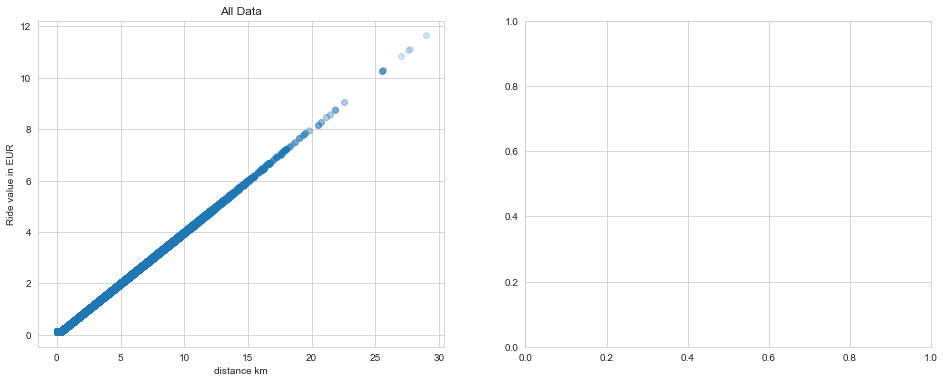

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df["distance_in_kilometers"], df["ride_value"], alpha=0.2)
axs[0].set_xlabel("distance km")
axs[0].set_ylabel("Ride value in EUR")
axs[0].set_title("All Data")

## Below graph shows that there is a direct relationship between "distance_in_kilometers" and "ride_value".
## Most likely they will have a high correlation, hence it will not add value

### Location based analysis
##### Location based analysis is performed in order to check the relationship between certain taxi points and taxi orders


In [24]:
df_1 = df[["start_lat","start_lng"]]
df_1 = df_1.applymap('{:,.2f}'.format)
df_1['concat_lat_long'] = [', '.join(str(x) for x in y) for y in map(tuple, df_1[['start_lat', 'start_lng']].values)]
df_1.groupby("concat_lat_long")['concat_lat_long'].count().sort_values(ascending=False).head(11)

concat_lat_long
59.44, 24.75    46842
59.43, 24.75    35522
59.44, 24.76    27804
59.43, 24.77    22938
59.43, 24.76    22110
59.44, 24.73    18697
59.44, 24.74    16961
59.44, 24.77    16099
59.43, 24.74    15508
59.43, 24.73    13660
59.42, 24.74    13201
Name: concat_lat_long, dtype: int64

In [25]:
Tallin_city_center = (59.43, 24.74)
Tallin_airport = (59.41, 24.80)
Location_recommendation_1 = (59.44, 24.75)
Location_recommendation_2 = (59.43, 24.75)
Location_recommendation_3 = (59.44, 24.76)
Location_recommendation_4 = (59.43, 24.77)
Location_recommendation_5 = (59.43, 24.76)
Location_recommendation_6 = (59.44, 24.73)
Location_recommendation_7 = (59.44, 24.74)
Location_recommendation_8 = (59.44, 24.77)
Location_recommendation_9 = (59.42, 24.74)
Location_recommendation_10 = (59.43, 24.73)

In [26]:
def plot_location_ride(loc, name, range=2):
     
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    idx = (distance(df["start_lat"], df["start_lng"], loc[0], loc[1]) < range)
    df[idx]["ride_value"].hist(bins = 100, ax=axs[0])
    axs[0].set_xlabel("Ride value EUR")
    axs[0].set_title("Histogram pickup location within {} km of {}".format(range, name))
    
    idx = (distance(df["end_lat"], df["end_lng"], loc[0], loc[1]) < range)
    df[idx]["ride_value"].hist(bins=100, ax=axs[1])
    axs[1].set_xlabel("Ride value EUR")
    axs[1].set_title("Histogram dropoff location within {} km of {}".format(range, name)) 

In [27]:
def plot_location_time_hour(loc, name, range=2):
    
    fig, axs = plt.subplots(1,2, figsize=(14,5))
    idx = (distance(df["start_lat"], df["start_lng"], loc[0], loc[1]) < range)
    df[idx]["hour"].hist(bins = 100, ax=axs[0])
    axs[0].set_xlabel("Day Time(in hours)")
    axs[0].set_title("Histogram pickup location within {} km of {}".format(range, name))
    
    idx = (distance(df["end_lat"], df["end_lng"], loc[0], loc[1]) < range)
    df[idx]["hour"].hist(bins=100, ax=axs[1])
    axs[1].set_xlabel("Day Time(in hours)")
    axs[1].set_title("Histogram dropoff location within {} km of {}".format(range, name))

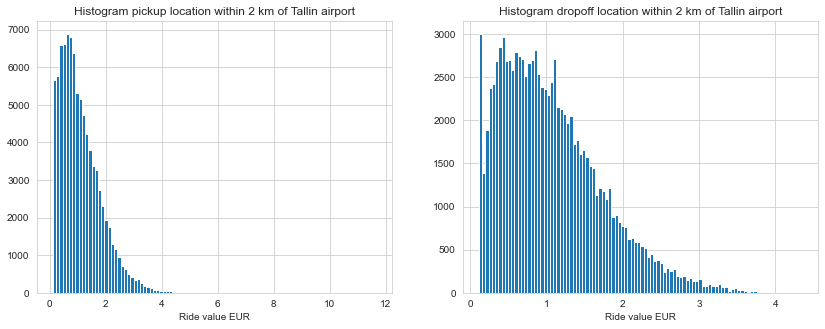

In [28]:
plot_location_ride(Tallin_airport, 'Tallin airport')

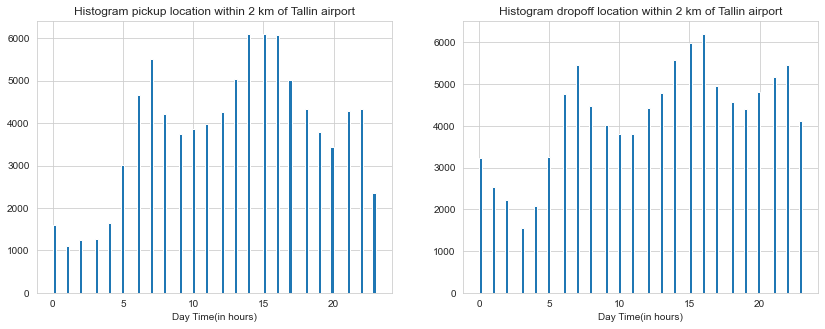

In [29]:
plot_location_time_hour(Tallin_airport, 'Tallin airport')

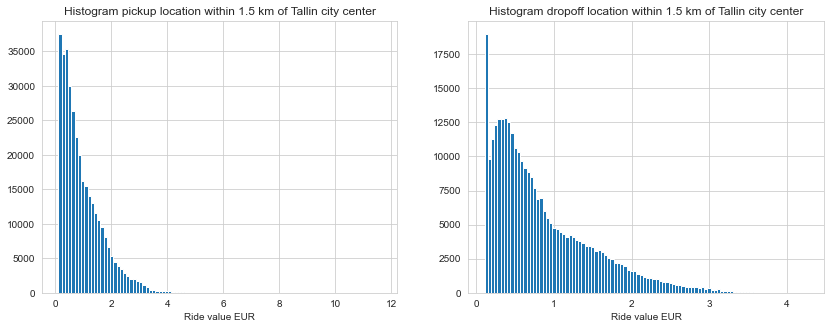

In [30]:
plot_location_ride(Tallin_city_center, 'Tallin city center',1.5)

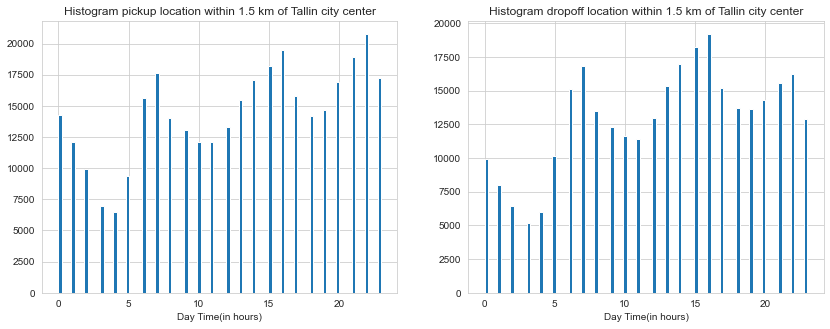

In [31]:
plot_location_time_hour(Tallin_city_center, 'Tallin city center',1.5)

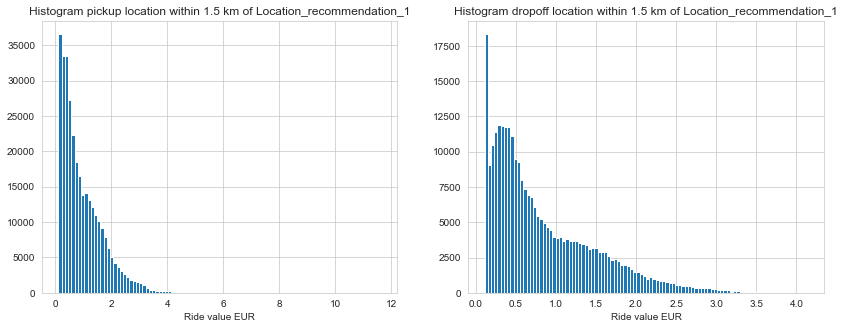

In [32]:
plot_location_ride(Location_recommendation_1, 'Location_recommendation_1',1.5)

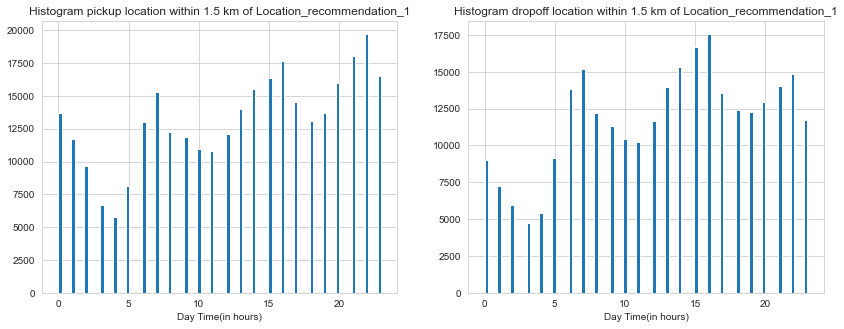

In [33]:
plot_location_time_hour(Location_recommendation_1, 'Location_recommendation_1',1.5)

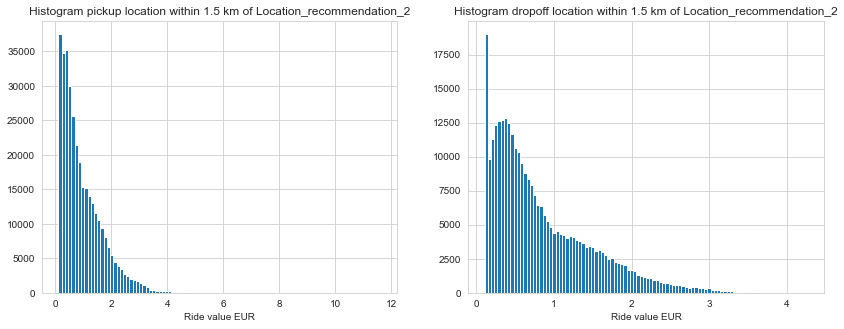

In [34]:
plot_location_ride(Location_recommendation_2, 'Location_recommendation_2',1.5)

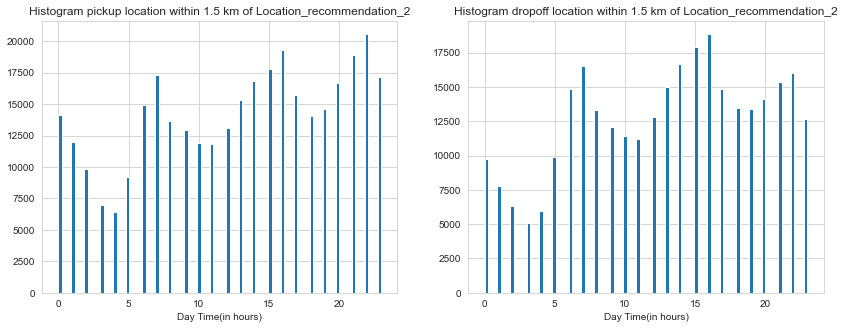

In [35]:
plot_location_time_hour(Location_recommendation_2, 'Location_recommendation_2',1.5)

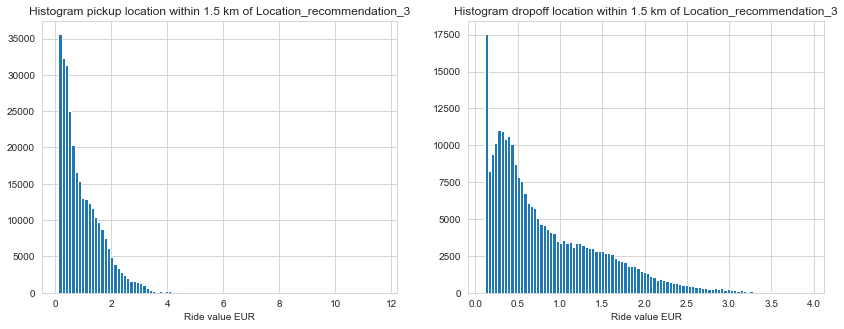

In [36]:
plot_location_ride(Location_recommendation_3, 'Location_recommendation_3',1.5)

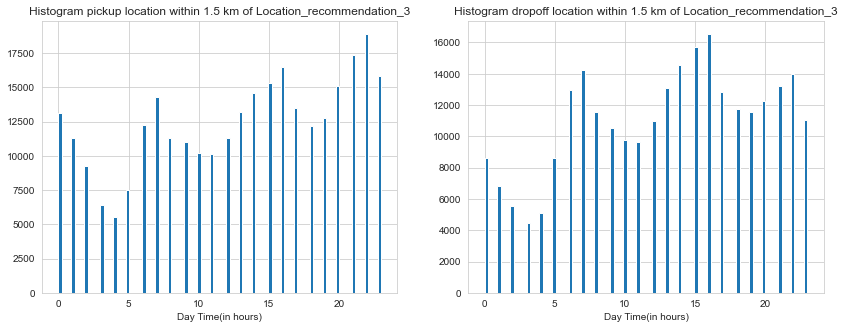

In [37]:
plot_location_time_hour(Location_recommendation_3, 'Location_recommendation_3',1.5)

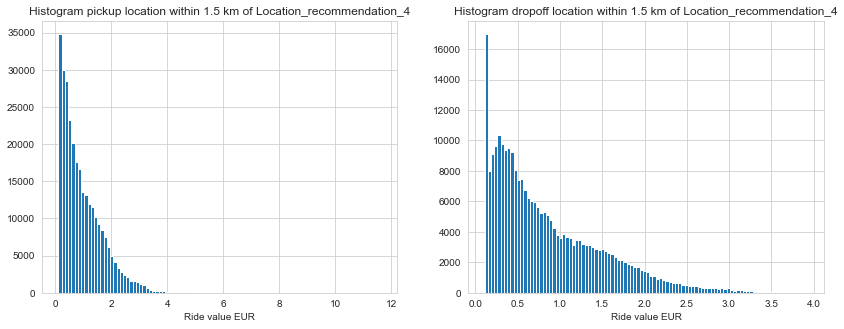

In [38]:
plot_location_ride(Location_recommendation_4, 'Location_recommendation_4',1.5)

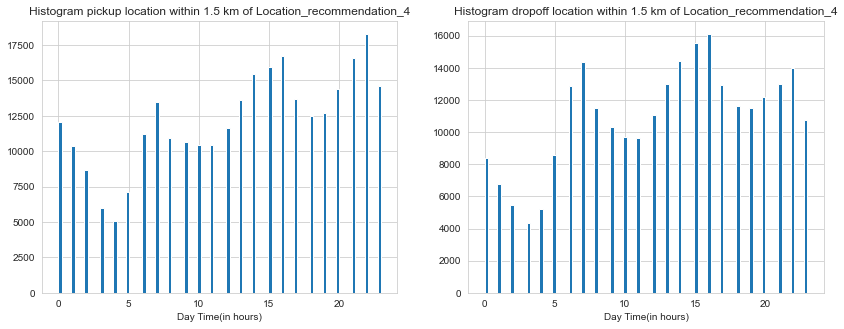

In [39]:
plot_location_time_hour(Location_recommendation_4, 'Location_recommendation_4',1.5)

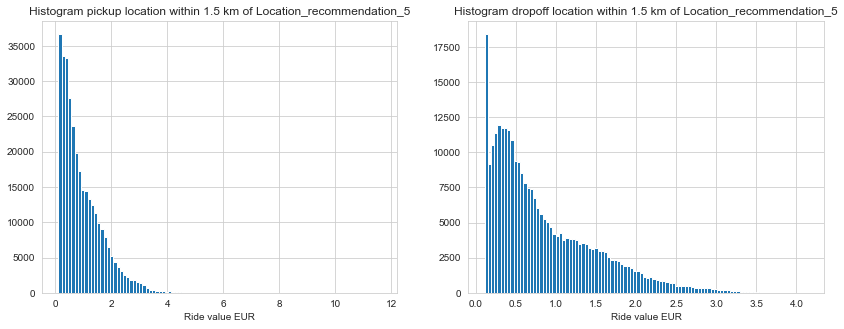

In [40]:
plot_location_ride(Location_recommendation_5, 'Location_recommendation_5',1.5)

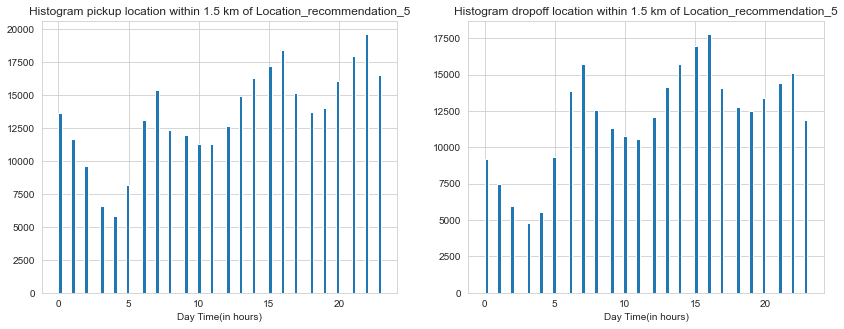

In [41]:
plot_location_time_hour(Location_recommendation_5, 'Location_recommendation_5',1.5)

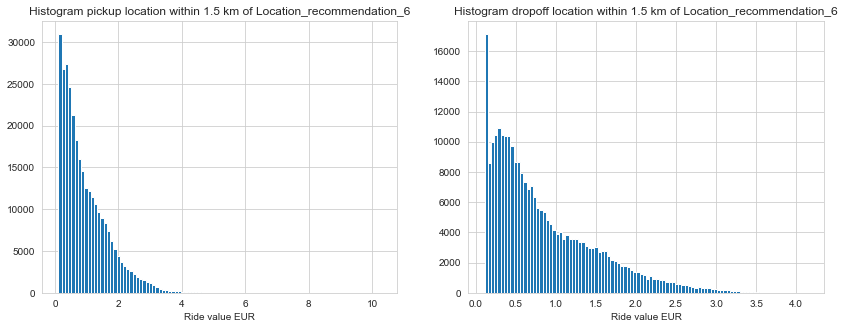

In [42]:
plot_location_ride(Location_recommendation_6, 'Location_recommendation_6',1.5)

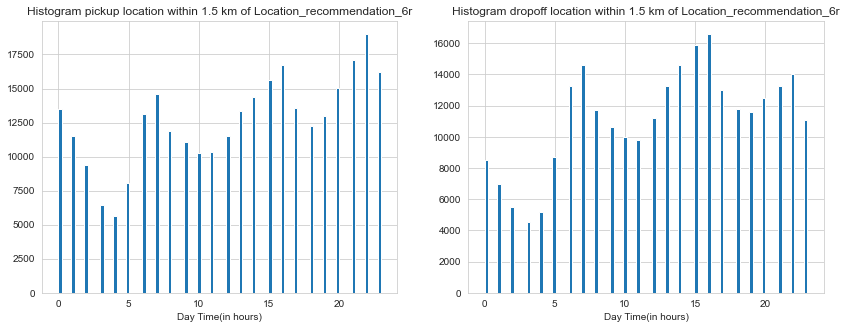

In [43]:
plot_location_time_hour(Location_recommendation_6, 'Location_recommendation_6r',1.5)

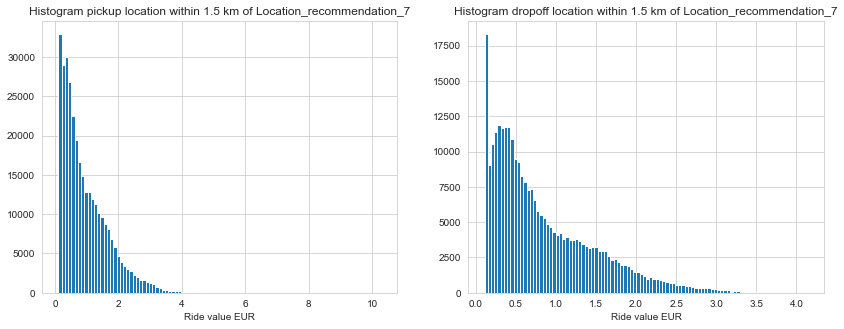

In [44]:
plot_location_ride(Location_recommendation_7, 'Location_recommendation_7',1.5)

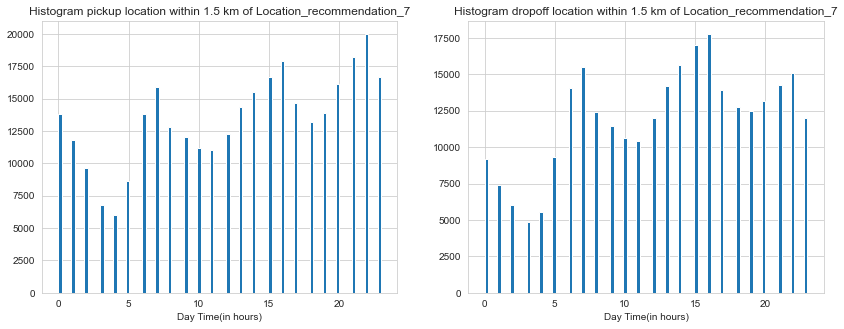

In [45]:
plot_location_time_hour(Location_recommendation_7, 'Location_recommendation_7',1.5)

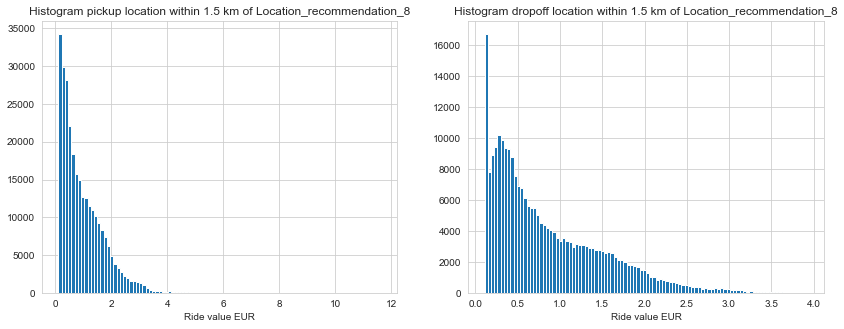

In [46]:
plot_location_ride(Location_recommendation_8, 'Location_recommendation_8',1.5)

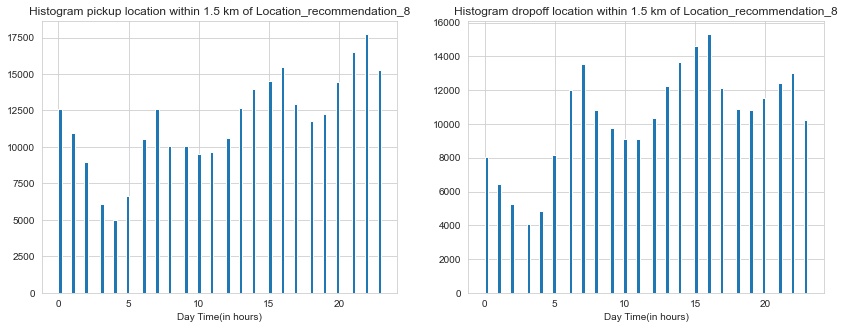

In [47]:
plot_location_time_hour(Location_recommendation_8, 'Location_recommendation_8',1.5)

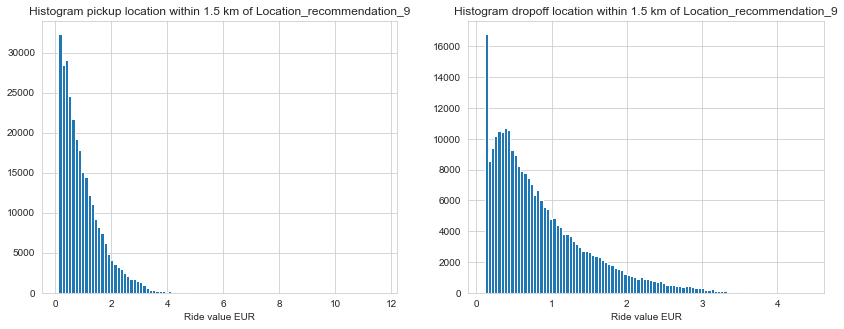

In [48]:
plot_location_ride(Location_recommendation_9, 'Location_recommendation_9',1.5)

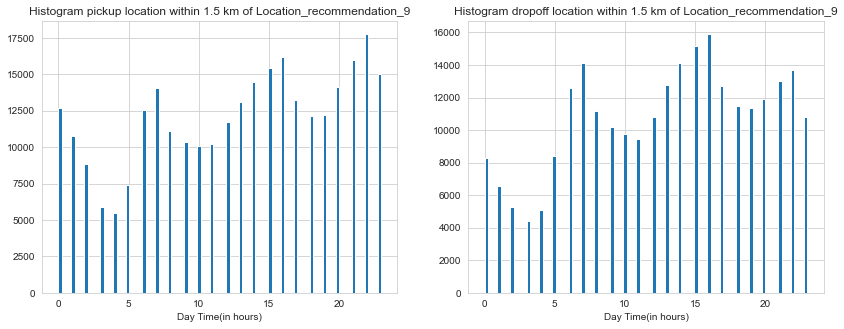

In [49]:
plot_location_time_hour(Location_recommendation_9, 'Location_recommendation_9',1.5)

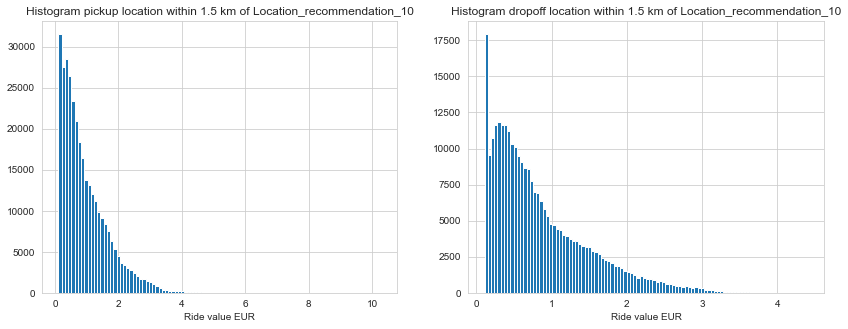

In [50]:
plot_location_ride(Location_recommendation_10, 'Location_recommendation_10',1.5)

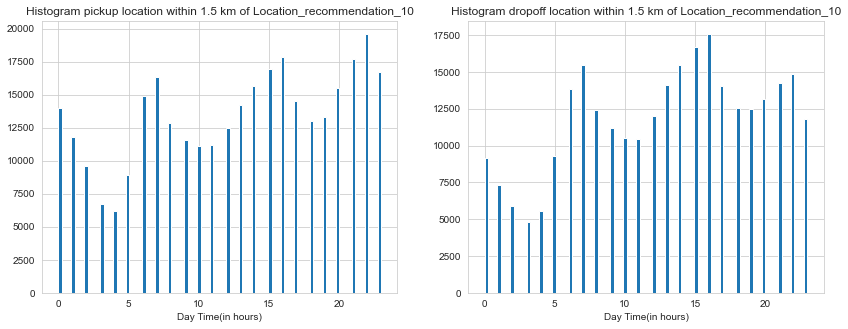

In [51]:
plot_location_time_hour(Location_recommendation_10, 'Location_recommendation_10',1.5)

## Ride value and pickup location

In [86]:
def plot_to_location_and_ride(name,name_2):
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    im = axs[0].scatter(df['name'], df["distance_in_kilometers"], c=np.clip(df["ride_value"], 0, 100), 
                         cmap='viridis', alpha=1.0, s=1)

    axs[0].set_xlabel('pickup distance from {}'.format(name_2))
    axs[0].set_ylabel('distance in km')
    axs[0].set_title('All data')

    cbar = fig.colorbar(im, ax=axs[0])
    cbar.ax.set_ylabel('ride_value', rotation=270)


    idx = (df['name'] < 15) & (df["distance_in_kilometers"] < 20)
    im = axs[1].scatter(df[idx]["distance_to_center"], df[idx]["distance_in_kilometers"], 
                         c=np.clip(df[idx]["ride_value"], 0, 100), cmap='viridis', alpha=1.0, s=1)
    axs[1].set_xlabel('pickup distance from {}'.format(name_2))
    axs[1].set_ylabel('distance in km')
    axs[1].set_title('Zoom in')
    cbar = fig.colorbar(im, ax=axs[1])
    cbar.ax.set_ylabel('ride_value', rotation=270);

In [99]:
df['distance_to_center'] = distance(Tallin_city_center[0], Tallin_city_center[1], df["start_lat"], df["start_lng"])
df['distance_to_Tallin_airport'] = distance(Tallin_airport[0], Tallin_airport[1], df["start_lat"], df["start_lng"])

In [71]:
df['Location_recommendation_1'] = distance(Location_recommendation_1[0], Location_recommendation_1[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_2'] = distance(Location_recommendation_2[0], Location_recommendation_2[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_3'] = distance(Location_recommendation_3[0], Location_recommendation_3[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_4'] = distance(Location_recommendation_4[0], Location_recommendation_4[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_5'] = distance(Location_recommendation_5[0], Location_recommendation_5[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_6'] = distance(Location_recommendation_6[0], Location_recommendation_6[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_7'] = distance(Location_recommendation_7[0], Location_recommendation_7[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_8'] = distance(Location_recommendation_8[0], Location_recommendation_8[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_9'] = distance(Location_recommendation_9[0], Location_recommendation_9[1], df["start_lat"], df["start_lng"])
df['Location_recommendation_10'] = distance(Location_recommendation_10[0], Location_recommendation_10[1], df["start_lat"], df["start_lng"])


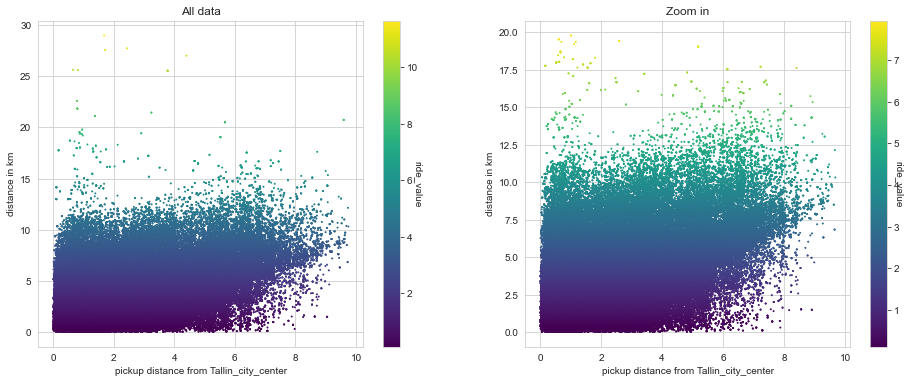

In [101]:
plot_to_location_and_ride(Tallin_city_center,'Tallin_city_center')

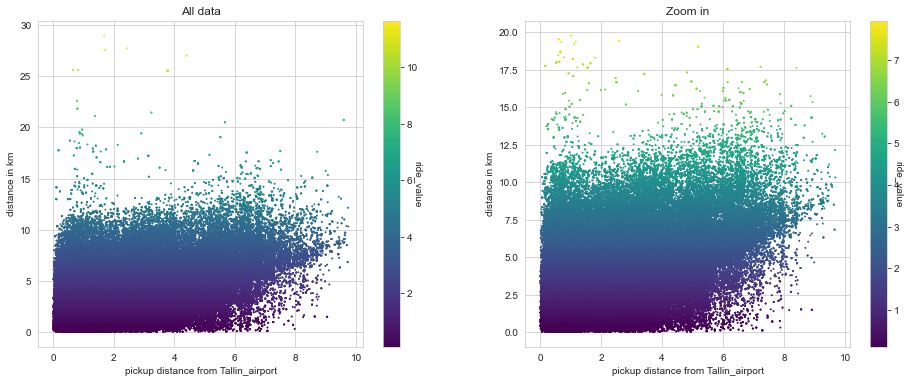

In [102]:
plot_to_location_and_ride(Tallin_airport,'Tallin_airport')

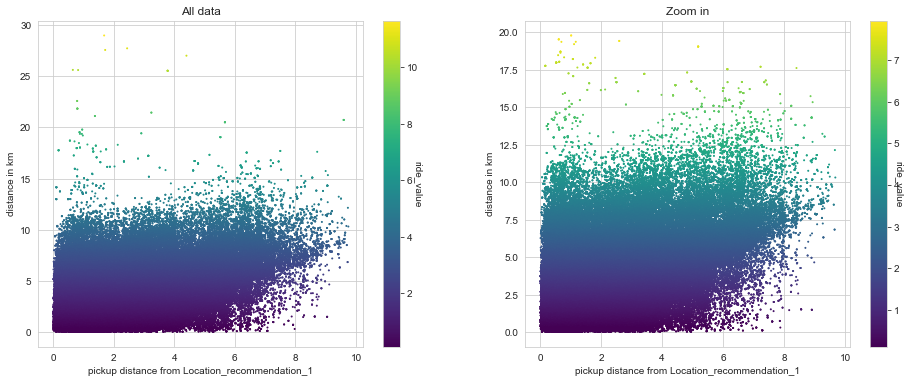

In [88]:
plot_to_location_and_ride(Location_recommendation_1,'Location_recommendation_1')

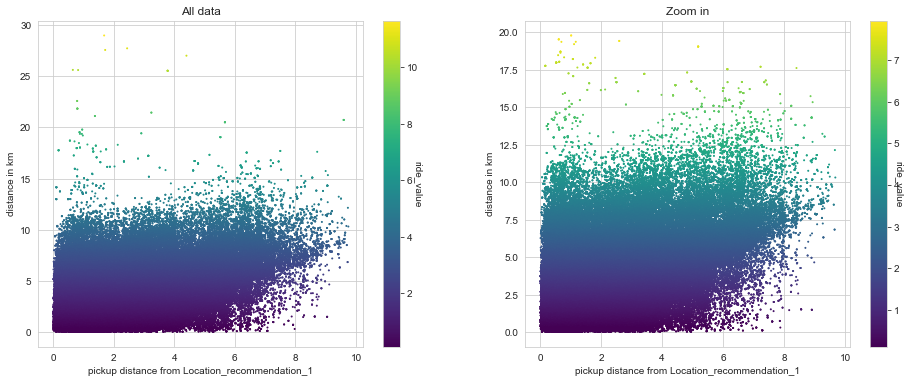

In [89]:
plot_to_location_and_ride(Location_recommendation_2,'Location_recommendation_2')

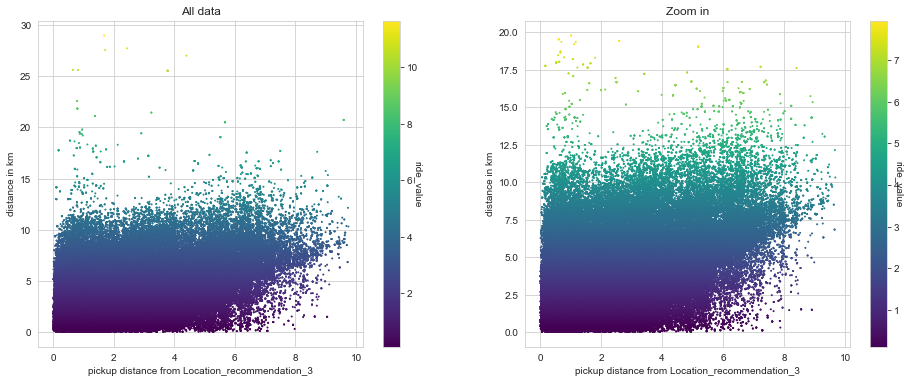

In [90]:
plot_to_location_and_ride(Location_recommendation_3,'Location_recommendation_3')

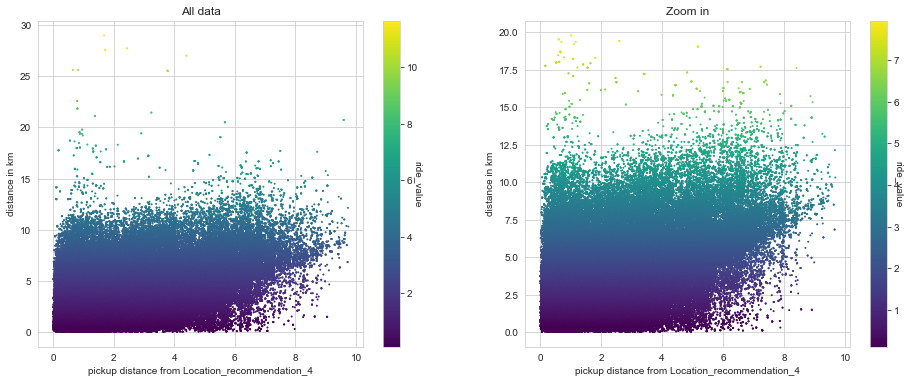

In [91]:
plot_to_location_and_ride(Location_recommendation_4,'Location_recommendation_4')

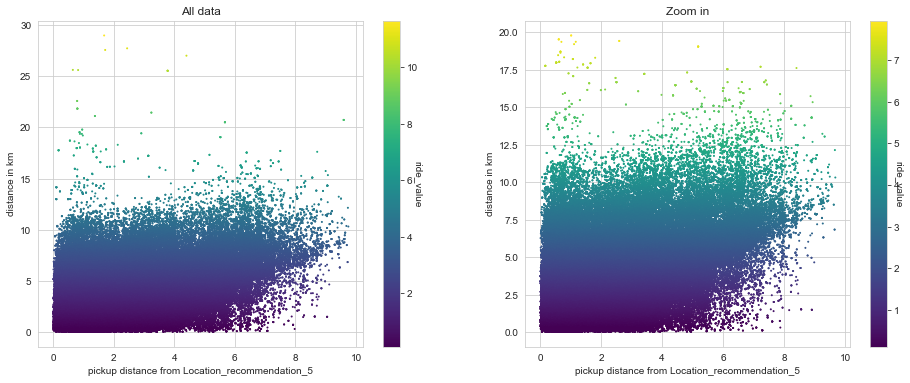

In [92]:
plot_to_location_and_ride(Location_recommendation_5,'Location_recommendation_5')

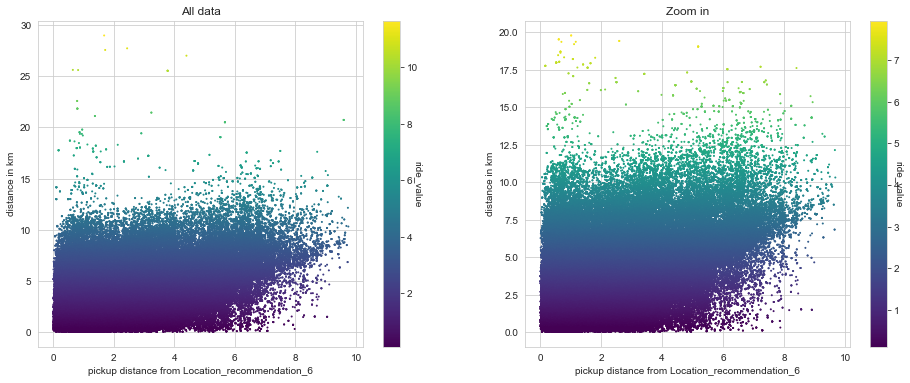

In [93]:
plot_to_location_and_ride(Location_recommendation_6,'Location_recommendation_6')

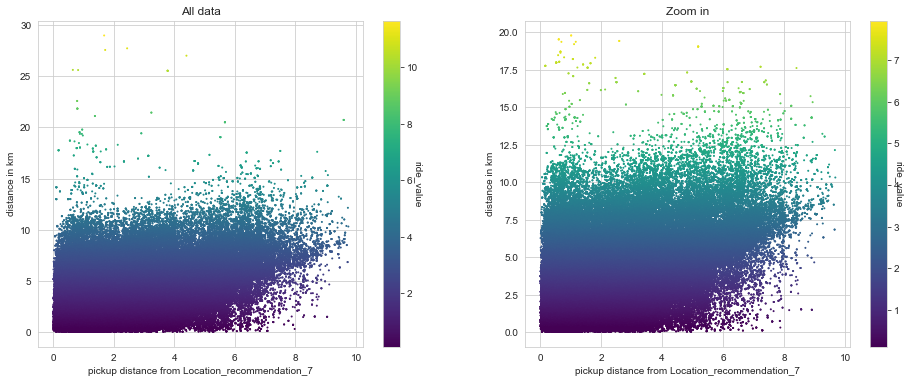

In [94]:
plot_to_location_and_ride(Location_recommendation_7,'Location_recommendation_7')

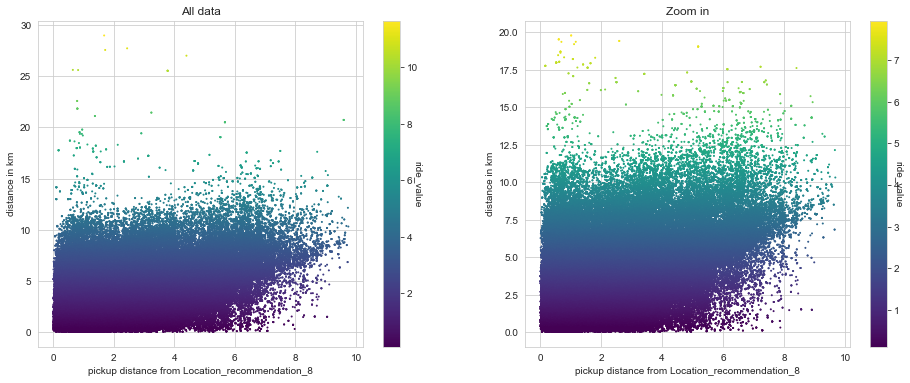

In [95]:
plot_to_location_and_ride(Location_recommendation_8,'Location_recommendation_8')

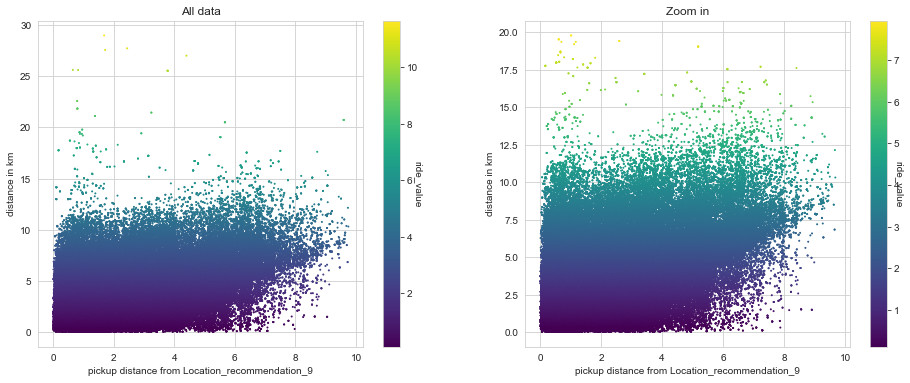

In [96]:
plot_to_location_and_ride(Location_recommendation_9,'Location_recommendation_9')

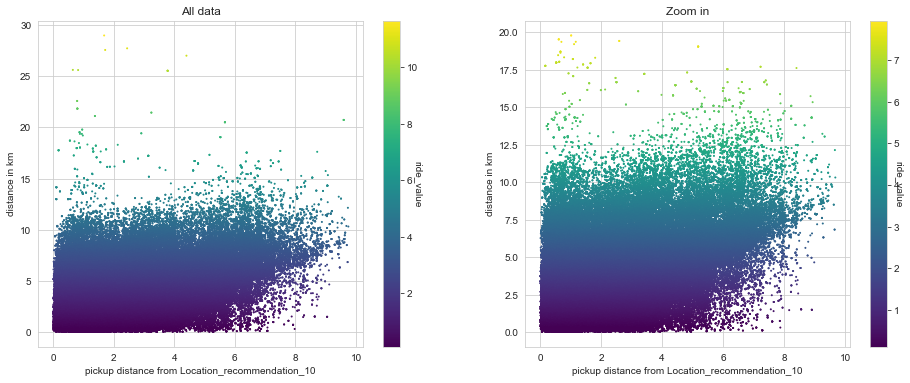

In [97]:
plot_to_location_and_ride(Location_recommendation_10,'Location_recommendation_10')

### ride_value_per_km analysis

In [101]:
df["ride_value_per_km"] = df["ride_value"] / df["distance_in_kilometers"]
df["ride_value_per_km"].describe()

count    622924.000000
mean          0.413291
std           0.302151
min           0.355080
25%           0.395377
50%           0.397108
75%           0.399558
max          36.259857
Name: ride_value_per_km, dtype: float64

Text(0, 0.5, 'ride per distance in km')

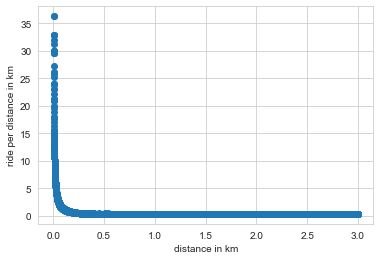

In [40]:
idx = (df["distance_in_kilometers"] < 3) & (df["ride_value"] < 100)
plt.scatter(df[idx]["distance_in_kilometers"], df[idx]["ride_value_per_km"])
plt.xlabel("distance in km")
plt.ylabel("ride per distance in km")

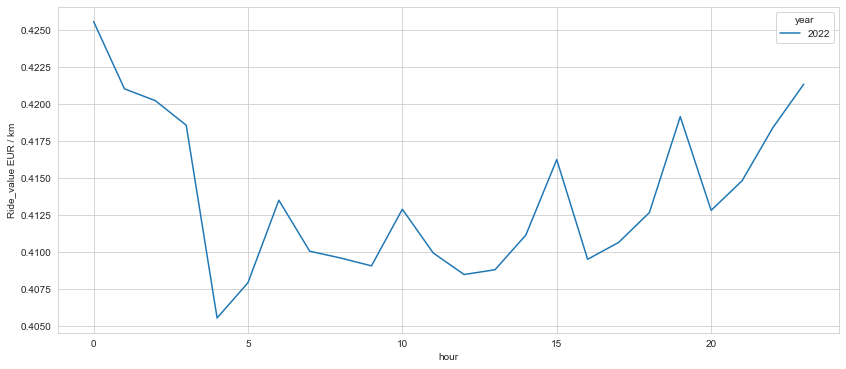

In [41]:
df.pivot_table("ride_value_per_km", index="hour", columns="year").plot(figsize=(14,6))
plt.ylabel("Ride_value EUR / km");

### Relevance of direction for calculation of ride amount

In [110]:
df["delta_lon"] = df["start_lng"] - df["end_lng"]
df["delta_lat"] = df["start_lat"] - df["end_lat"]

Text(0.5, 1.0, 'log1p(ride_value)')

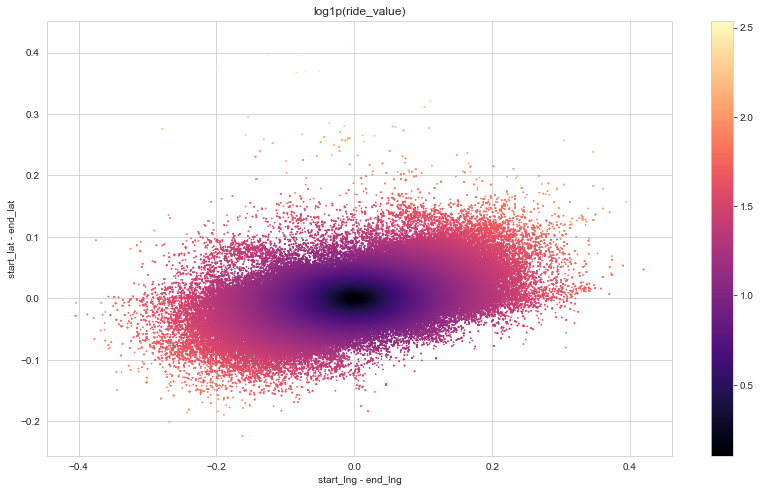

In [111]:
plt.figure(figsize=(14,8))
plt.scatter(df["delta_lon"], df["delta_lat"], s=0.5, alpha=1.0,
            c=np.log1p(df["ride_value"]), cmap="magma")
plt.colorbar()
plt.xlabel('start_lng - end_lng')
plt.ylabel('start_lat - end_lat')
plt.title('log1p(ride_value)')

##### above graph indicates that that there is a relationship between the ride direction and the ride value

##### Ride direction based analysis

In [112]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [113]:
df['direction'] = calculate_direction(df.delta_lon, df.delta_lat)

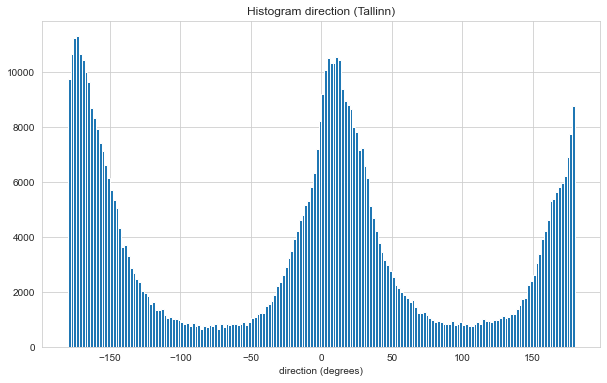

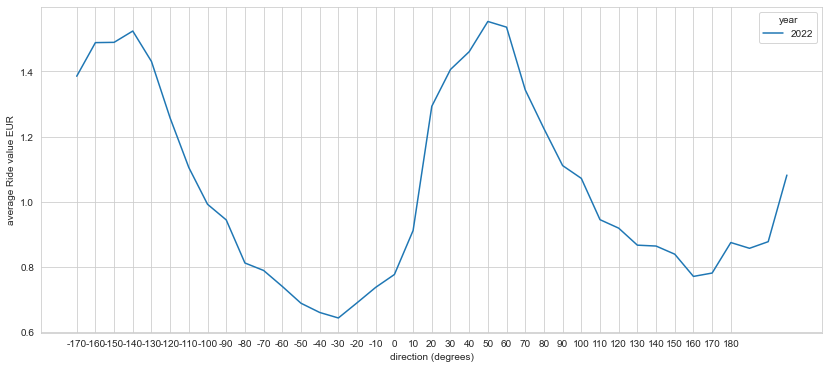

In [114]:
# plot histogram of directions
plt.figure(figsize=(10,6))
df.direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction (Tallinn)')

# plot direction vs average ride value amount
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df['direction'], np.linspace(-180, 180, 40))

df.pivot_table('ride_value', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)

plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average Ride value EUR');

In [146]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['ride_value','year','start_time','name','distance_in_kilometers'], axis=1)
y = df['ride_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Model Development

## Random Forest Regression

In [147]:
rf = RandomForestRegressor(max_depth = 6, max_features = 'sqrt', min_samples_leaf= 0.1, n_estimators= 400)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=0.1,
                      n_estimators=400)

In [148]:
from sklearn.metrics import mean_squared_error as MSE
 
y_pred = rf.predict(X_test)

rmse_test = np.sqrt(MSE(y_test, y_pred))

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('R_squared score: %.2f' %r2_score(y_test, y_pred))

Test set RMSE of rf: 0.63
R_squared score: 0.49


##### Feature importances

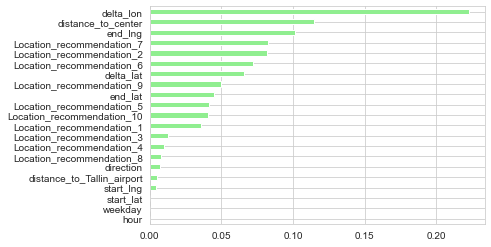

In [149]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf                                 
sorted_importances_rf = importances_rf.sort_values() 
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen'); 
plt.show()


##### Searching for the best hyperparameters

In [159]:
from sklearn.model_selection import GridSearchCV
# Define a grid of hyperparameter 'params_rf'
params_rf = {
            'n_estimators': [300, 400, 500],
            'max_depth': [4, 6, 8],
            'min_samples_leaf': [0.1, 0.2],
            'max_features': ['log2', 'sqrt']
            }
# Instantiate 'grid_rf'
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf, 
                       cv=3,  
                       scoring='neg_mean_squared_error', 
                       verbose=1,         
                       n_jobs=-1)
# Fit 'grid_rf' to the training set
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=8, max_features='sqrt',
                                             min_samples_leaf=0.1,
                                             n_estimators=400),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.1, 0.2],
                         'n_estimators': [300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [160]:
# Extract the best hyperparameters from 'grid_rf'
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 400}


###### Evaluating the best model performance

In [161]:
# Extract the best model from 'grid_rf'
best_model = grid_rf.best_estimator_
# Predict the test set labels
y_pred = best_model.predict(X_test)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
# Explained variance score
print('R_squared score: %.2f' %r2_score(y_test, y_pred))

Test set RMSE of rf: 0.63
R_squared score: 0.49


### XGBoost - Decision trees as base learners

In [157]:
import xgboost as xgb
 
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=10,seed=123)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print('R_squared score: %.2f' %r2_score(y_test, y_pred))

RMSE: 0.062083
R_squared score: 0.49


### XGBoost - Linear base learners

In [151]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear","objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))
print('R_squared score: %.2f' %r2_score(y_test, y_pred))

RMSE: 43.350391
R_squared score: 0.49


##### evaluating model quality

In [152]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0        0.626174       0.000548       0.626136      0.001138
1        0.474279       0.004257       0.474328      0.004180
2        0.358287       0.005069       0.358352      0.005196
3        0.270871       0.004869       0.270936      0.005106
4        0.204344       0.001447       0.204366      0.001749
4    0.204366
Name: test-mae-mean, dtype: float64


##### using regularization in XGBoost

In [153]:
# Create the DMatrix: housing_dmatrix
data_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=data_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2      rmse
0    1  0.359071
1   10  0.360399
2  100  0.366935


##### xgboost - Visualizing feature importances

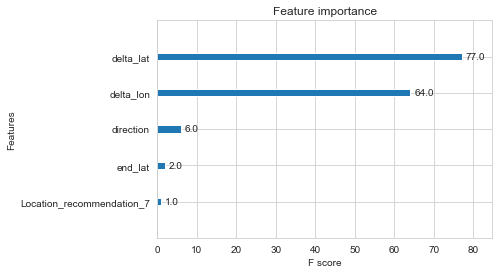

In [154]:
# Create the DMatrix:  dmatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain= dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()